# 1 Random Forests

### 1.1 Predicting Hospital Readmission

Using the `diabetes_data_clean` data set from previous examples, suppose we want to use random forests to build a model for predicting whether or not a patient will be later re-admitted

In [118]:
library(ranger)
library(randomForest)
library(tidyverse)

titanic_raw <- read.csv("diabetes_data_clean.csv")

In [119]:
# exclude identifier variables

titanic <- titanic_raw %>%
             select(-c(encounter_id, patient_nbr, weight, medical_specialty, payer_code, diag_1, diag_2, diag_3)) %>%
             filter(complete.cases(.))



### 1.2 Specify Subsets for Training and Test 

In [120]:
n_total <- nrow(titanic)
n_train <- floor(0.80 * n_total)

train <- sample(1:n_total, n_train)
test <- setdiff(1:n_total, train)

In [121]:
titanic$readmitted <- titanic$readmitted != "NO"

### 1.3 Fit Random Forest

In [136]:
fm1 <- ranger(factor(readmitted) ~ ., 
              data = titanic[train, ], 
              importance = "impurity", 
              num.tree = 1000,
              mtry = 10,
              min.node.size = 20)

Growing trees.. Progress: 66%. Estimated remaining time: 16 seconds.


In [137]:
show(fm1)

Ranger result

Call:
 ranger(factor(readmitted) ~ ., data = titanic[train, ], importance = "impurity",      num.tree = 1000, mtry = 10, min.node.size = 20) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      69466 
Number of independent variables:  41 
Mtry:                             10 
Target node size:                 20 
Variable importance mode:         impurity 
OOB prediction error:             36.53 % 


In [139]:
yhat <- predict(fm1, titanic[test, ])
mean(titanic[test, "readmitted"] == yhat$predictions)   # test error 

[1] 0.6432314

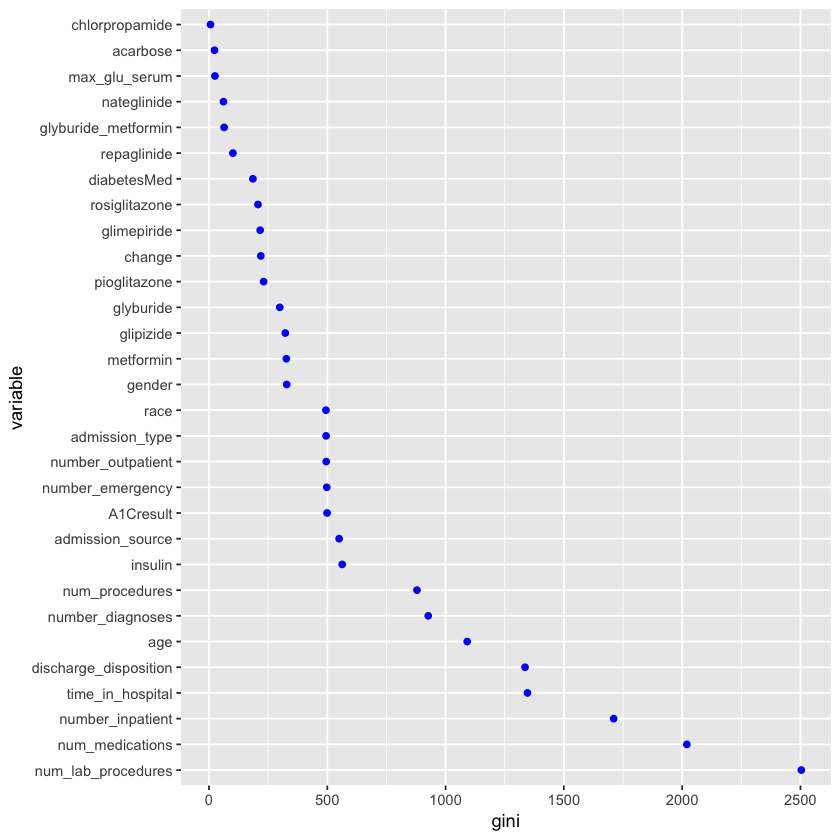

In [141]:
# Plotting variable importance

imp <- sort(ranger::importance(fm1), decreasing = TRUE)
imp_vals <- data.frame(gini = imp)
imp_vals$variable <- factor(names(imp), levels = names(imp))

ggplot(imp_vals[1:30, ], aes(x = gini, y = variable)) +
    geom_point(colour = "blue")

In [108]:
fm2 <- randomForest(factor(readmitted) ~ ., 
                    data = titanic[train, ], 
                    importance = TRUE,
                    ntree = 500)

In [111]:
show(fm2)


Call:
 randomForest(formula = factor(readmitted) ~ ., data = titanic[train,      ], importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 36.35%
Confusion matrix:
      FALSE  TRUE class.error
FALSE 19618  8293   0.2971230
TRUE  10645 13543   0.4400943


In [117]:
yhat <- predict(fm2, titanic[test, ])
mean(titanic[test, "readmitted"] == yhat)

[1] 0.6360051

---

---

# 2 Speed Benchmark in R

### 2.1 Truncating Near-Zero Values

In [142]:
trunc_near_zeros <- function(A, thresh) {
    n <- nrow(A)
    p <- ncol(A)
    
    for (j in 1:p) {
        for (i in 1:n) {
            if (abs(A[i, j]) < thresh) {
                A[i, j] <- 0.0
            }
        }
    }
    return(A)
}

In [145]:
n <- 1000000
p <- 100
X <- matrix(rnorm(n * p), ncol = p) 

In [ ]:
system.time(expr = {
    X2 <- trunc_near_zeros(X, 0.001)
})

---

---

---

---

In [ ]:
trunc_near_zeros2 <- function(dat, thresh) {
    p <- ncol(dat)
    for (j in 1:p) {
        dat[, j] <- ifelse(abs(dat[, j]) < thresh, 0.0, dat[, j])
    }
    return(dat)
}

In [ ]:
n <- 500000
df1 <- data.frame(a = rnorm(n),
                  b = rnorm(n),
                  c = rnorm(n), 
                  d = rnorm(n))

system.time(expr = {df2 <- trunc_near_zeros2(df1, 0.01)})

In [ ]:
trunc_near_zeros3 <- function(dat, thresh) {
    dat[abs(dat) < thresh] <- 0.0 
    return(dat)
}

In [ ]:
n <- 1000000
p <- 100
X <- matrix(rnorm(n * p), ncol = p) 

system.time(expr = {X2 <- trunc_near_zeros3(X, 0.001)})